Žygimantas Augustas Nemura 2110605 [Strawberry, Horse, Cat]

In [51]:
!pip install fiftyone
!pip install "pydantic<2.0" --quiet

In [52]:
#!rm -rf ./saved_predictions

Atsisiunciam nuotraukas

In [53]:
import fiftyone.zoo as foz
import fiftyone as fo
import os


save_dir = "./saved_predictions"
os.makedirs(save_dir, exist_ok=True)

#Atsisiunciame nuotraukas
train_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples= 1000,
    only_matching=True,
)

test_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="test",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples=100,
    only_matching=True,
)

val_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples=100,
    only_matching=True,
)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


Found 500 images, downloading the remaining 500


INFO:fiftyone.utils.openimages:Found 500 images, downloading the remaining 500


 100% |███████████████████| 500/500 [1.1m elapsed, 0s remaining, 6.1 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 500/500 [1.1m elapsed, 0s remaining, 6.1 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |███████████████| 1000/1000 [54.1s elapsed, 0s remaining, 14.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [54.1s elapsed, 0s remaining, 14.9 samples/s]      


Dataset 'open-images-v6-train-1000' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-train-1000' created


INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v6/test' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'test' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'test' is sufficient


Loading existing dataset 'open-images-v6-test-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v6-test-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'open-images-v6-validation-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v6-validation-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Dataset

In [54]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class Lab3Dataset(Dataset):
    def __init__(self, fiftyone_dataset, transforms=None):
        self.samples = list(fiftyone_dataset)
        self.transforms = transforms
        self.class_to_idx = {"Strawberry": 1, "Horse": 2, "Cat": 3}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        image = Image.open(sample.filepath).convert("RGB")
        W, H = image.size

        mask = np.zeros((H, W), dtype=np.uint8)

        detections = sample.ground_truth.detections if sample.ground_truth else []

        for det in detections:
            label = det.label
            if label not in self.class_to_idx:
                continue

            if det.mask is not None:
                instance_mask = np.array(det.mask, dtype=np.uint8)

                x_rel, y_rel, w_rel, h_rel = det.bounding_box
                x0 = int(x_rel * W)
                y0 = int(y_rel * H)
                x1 = int((x_rel + w_rel) * W)
                y1 = int((y_rel + h_rel) * H)

                box_w, box_h = x1 - x0, y1 - y0
                resized_mask = np.array(
                    Image.fromarray(instance_mask).resize((box_w, box_h), resample=Image.NEAREST)
                )

                if resized_mask.shape[0] == 0 or resized_mask.shape[1] == 0:
                    continue

                class_id = self.class_to_idx[label]

                mask[y0:y1, x0:x1][resized_mask > 0] = class_id

        if self.transforms:
            augmented = self.transforms(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

Transformacijos

In [55]:
!pip install "albumentations<1.4.0"

In [56]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

test_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

Susikuriam datasetis

In [57]:
from torch.utils.data import DataLoader

train_set = Lab3Dataset(train_dataset, transforms=train_transform)
test_set = Lab3Dataset(test_dataset, transforms=test_transform)
val_set = Lab3Dataset(val_dataset, transforms=val_transform)

Pasiziurim, kas yra datasete

File: /root/fiftyone/open-images-v6/train/data/00616ae2135bc076.jpg
Image shape: (256, 256, 3)
Mask shape: (256, 256)


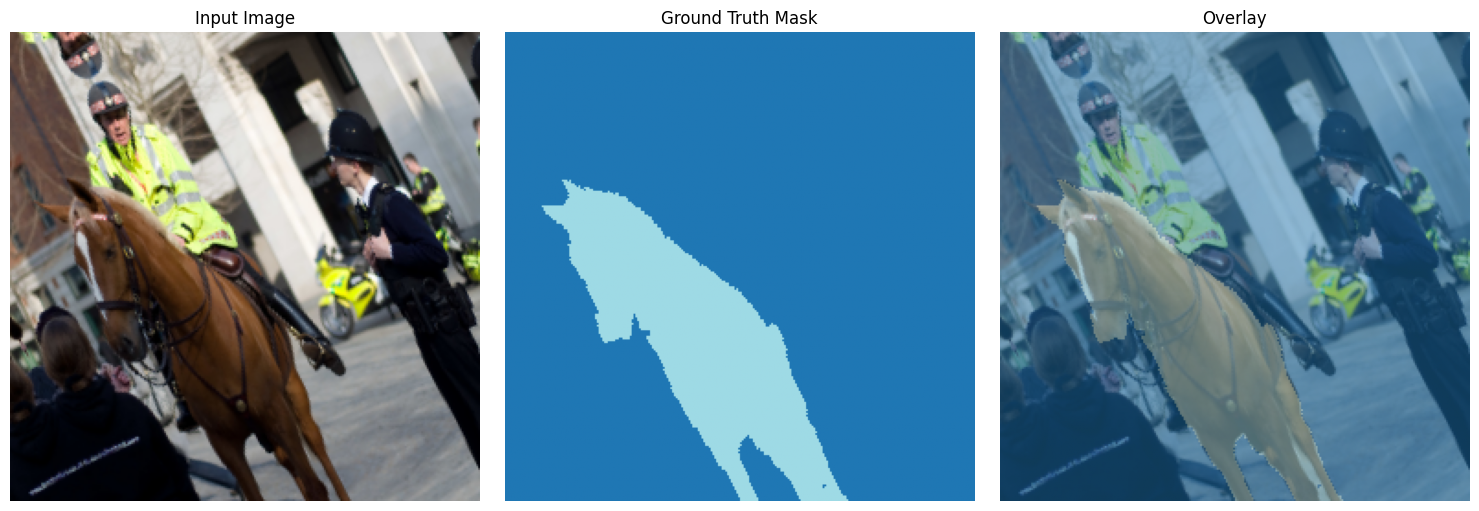

In [58]:
import matplotlib.pyplot as plt

sample_idx = 80

sample_image, sample_mask = train_set[sample_idx]

print("File:", train_set.samples[sample_idx].filepath)
if isinstance(sample_image, torch.Tensor):
    sample_image = sample_image.permute(1, 2, 0).cpu().numpy()

if isinstance(sample_mask, torch.Tensor):
    sample_mask = sample_mask.cpu().numpy()

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask, cmap="tab20")
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_image)
plt.imshow(sample_mask, cmap="tab20", alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()


Dataloader

In [59]:
train_loader = DataLoader(train_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=False)
val_loader = DataLoader(val_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=False)

Modelis

In [60]:
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #Up
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

Paruosiam modeli darbui

In [61]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-61-fd73dae578de>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Treniravimas

In [62]:
from pickle import TRUE
from tqdm import tqdm
import torch.optim as optium

NUM_EPOCHS = 60

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = []
    loop = tqdm(train_loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss.append(loss.item())
        loop.set_postfix(loss=loss.item())

    model.eval()
    val_loss = []

    with torch.no_grad():
        val_loop = tqdm(val_loader)
        for val_batch_idx, (val_data, val_targets) in enumerate(val_loop):
            val_data = val_data.to(device=DEVICE)
            val_targets = val_targets.to(device=DEVICE)

            with torch.cuda.amp.autocast():
                val_predictions = model(val_data)
                loss = loss_fn(val_predictions, val_targets)

            val_loss.append(loss.item())
            val_loop.set_postfix(loss=loss.item())

    avg_train_loss = sum(train_loss) / len(train_loss)
    avg_val_loss = sum(val_loss) / len(val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  0%|          | 0/63 [00:00<?, ?it/s]<ipython-input-62-56eeedab1a46>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-62-56eeedab1a46>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=1.09]


Epoch [1/60], Train Loss: 1.2450, Val Loss: 1.1595


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, loss=0.86]


Epoch [2/60], Train Loss: 0.9733, Val Loss: 0.9068


100%|██████████| 7/7 [00:02<00:00,  2.78it/s, loss=0.851]


Epoch [3/60], Train Loss: 0.8695, Val Loss: 0.9218


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.557]


Epoch [4/60], Train Loss: 0.7908, Val Loss: 0.7645


100%|██████████| 7/7 [00:01<00:00,  4.55it/s, loss=0.533]


Epoch [5/60], Train Loss: 0.7315, Val Loss: 0.7068


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, loss=0.464]


Epoch [6/60], Train Loss: 0.6894, Val Loss: 0.6886


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.435]


Epoch [7/60], Train Loss: 0.6505, Val Loss: 0.6162


100%|██████████| 7/7 [00:01<00:00,  4.62it/s, loss=0.423]


Epoch [8/60], Train Loss: 0.6136, Val Loss: 0.5875


100%|██████████| 7/7 [00:01<00:00,  4.55it/s, loss=0.353]


Epoch [9/60], Train Loss: 0.5944, Val Loss: 0.5393


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, loss=0.431]


Epoch [10/60], Train Loss: 0.5697, Val Loss: 0.5425


100%|██████████| 7/7 [00:01<00:00,  4.69it/s, loss=0.373]


Epoch [11/60], Train Loss: 0.5529, Val Loss: 0.4899


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.396]


Epoch [12/60], Train Loss: 0.5372, Val Loss: 0.5336


100%|██████████| 7/7 [00:01<00:00,  4.54it/s, loss=0.268]


Epoch [13/60], Train Loss: 0.5204, Val Loss: 0.5348


100%|██████████| 7/7 [00:01<00:00,  4.62it/s, loss=0.38]


Epoch [14/60], Train Loss: 0.5140, Val Loss: 0.4888


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.287]


Epoch [15/60], Train Loss: 0.4981, Val Loss: 0.4179


100%|██████████| 7/7 [00:01<00:00,  4.71it/s, loss=0.276]


Epoch [16/60], Train Loss: 0.4882, Val Loss: 0.4228


100%|██████████| 7/7 [00:01<00:00,  4.41it/s, loss=0.24]


Epoch [17/60], Train Loss: 0.4807, Val Loss: 0.4482


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, loss=0.251]


Epoch [18/60], Train Loss: 0.4719, Val Loss: 0.4200


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=0.212]


Epoch [19/60], Train Loss: 0.4658, Val Loss: 0.4103


100%|██████████| 7/7 [00:01<00:00,  4.76it/s, loss=0.233]


Epoch [20/60], Train Loss: 0.4543, Val Loss: 0.3843


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.241]


Epoch [21/60], Train Loss: 0.4455, Val Loss: 0.4053


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.184]


Epoch [22/60], Train Loss: 0.4434, Val Loss: 0.3978


100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=0.225]


Epoch [23/60], Train Loss: 0.4294, Val Loss: 0.3669


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.285]


Epoch [24/60], Train Loss: 0.4235, Val Loss: 0.3838


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=0.185]


Epoch [25/60], Train Loss: 0.4196, Val Loss: 0.3392


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=0.239]


Epoch [26/60], Train Loss: 0.4215, Val Loss: 0.4035


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.169]


Epoch [27/60], Train Loss: 0.4166, Val Loss: 0.3409


100%|██████████| 7/7 [00:01<00:00,  4.58it/s, loss=0.171]


Epoch [28/60], Train Loss: 0.3956, Val Loss: 0.3670


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.179]


Epoch [29/60], Train Loss: 0.3948, Val Loss: 0.3448


100%|██████████| 7/7 [00:01<00:00,  4.68it/s, loss=0.211]


Epoch [30/60], Train Loss: 0.3974, Val Loss: 0.3690


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.245]


Epoch [31/60], Train Loss: 0.3870, Val Loss: 0.3719


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=0.169]


Epoch [32/60], Train Loss: 0.4027, Val Loss: 0.3532


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, loss=0.153]


Epoch [33/60], Train Loss: 0.3754, Val Loss: 0.3399


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.219]


Epoch [34/60], Train Loss: 0.3815, Val Loss: 0.3817


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=0.19]


Epoch [35/60], Train Loss: 0.3732, Val Loss: 0.3290


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.186]


Epoch [36/60], Train Loss: 0.3649, Val Loss: 0.3905


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=0.188]


Epoch [37/60], Train Loss: 0.3639, Val Loss: 0.3207


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=0.268]


Epoch [38/60], Train Loss: 0.3661, Val Loss: 0.4109


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=0.134]


Epoch [39/60], Train Loss: 0.3634, Val Loss: 0.2974


100%|██████████| 7/7 [00:01<00:00,  4.68it/s, loss=0.253]


Epoch [40/60], Train Loss: 0.3588, Val Loss: 0.3468


100%|██████████| 7/7 [00:01<00:00,  4.13it/s, loss=0.378]


Epoch [41/60], Train Loss: 0.3564, Val Loss: 0.3705


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.167]


Epoch [42/60], Train Loss: 0.3478, Val Loss: 0.3212


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, loss=0.152]


Epoch [43/60], Train Loss: 0.3413, Val Loss: 0.3124


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.153]


Epoch [44/60], Train Loss: 0.3296, Val Loss: 0.2907


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.163]


Epoch [45/60], Train Loss: 0.3354, Val Loss: 0.3032


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=0.12]


Epoch [46/60], Train Loss: 0.3305, Val Loss: 0.2741


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.179]


Epoch [47/60], Train Loss: 0.3161, Val Loss: 0.2869


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, loss=0.155]


Epoch [48/60], Train Loss: 0.3263, Val Loss: 0.3436


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.186]


Epoch [49/60], Train Loss: 0.3242, Val Loss: 0.3129


100%|██████████| 7/7 [00:01<00:00,  4.56it/s, loss=0.144]


Epoch [50/60], Train Loss: 0.3264, Val Loss: 0.2852


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=0.214]


Epoch [51/60], Train Loss: 0.3096, Val Loss: 0.3052


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=0.185]


Epoch [52/60], Train Loss: 0.3102, Val Loss: 0.2682


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.179]


Epoch [53/60], Train Loss: 0.2996, Val Loss: 0.2813


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=0.122]


Epoch [54/60], Train Loss: 0.3116, Val Loss: 0.3075


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.136]


Epoch [55/60], Train Loss: 0.3032, Val Loss: 0.2844


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=0.131]


Epoch [56/60], Train Loss: 0.3007, Val Loss: 0.2896


100%|██████████| 7/7 [00:01<00:00,  4.70it/s, loss=0.174]


Epoch [57/60], Train Loss: 0.2973, Val Loss: 0.3333


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.138]


Epoch [58/60], Train Loss: 0.2895, Val Loss: 0.2928


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=0.124]


Epoch [59/60], Train Loss: 0.2916, Val Loss: 0.2857


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=0.141]

Epoch [60/60], Train Loss: 0.2761, Val Loss: 0.3075


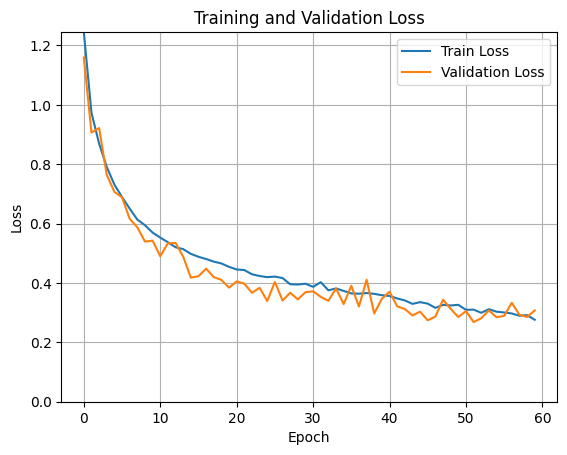

In [67]:
epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.ylim(0, max(max(train_losses), max(val_losses)))
plt.show()

In [64]:
def save_predictions(loader, model, device, save_dir="./saved_predictions"):
    model.eval()
    with torch.no_grad():
        for idx, (data, targets) in enumerate(loader):
            data = data.to(device)
            targets = targets.to(device)

            preds = model(data)
            preds = torch.argmax(preds, dim=1)

            for i in range(data.shape[0]):
                pred_mask = preds[i].cpu().numpy().astype(np.uint8)
                gt_mask = targets[i].cpu().numpy().astype(np.uint8)

                pred_img = Image.fromarray(pred_mask * 80)
                gt_img = Image.fromarray(gt_mask * 80)

                pred_img.save(os.path.join(save_dir, f"pred_{idx}_{i}.png"))
                gt_img.save(os.path.join(save_dir, f"gt_{idx}_{i}.png"))

save_predictions(test_loader, model, DEVICE, save_dir="./saved_predictions")

Testavimas ir metriku skaiciavimas

In [65]:
!pip install torchmetrics
!pip install -U torchmetrics

In [66]:
from torchmetrics.classification import MulticlassF1Score
import torch.nn.functional as F

def dice_score(preds, targets, num_classes, epsilon=1e-6):
    dices = []
    preds = preds.flatten()
    targets = targets.flatten()

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls

        intersection = (pred_inds & target_inds).sum().float()
        total = pred_inds.sum().float() + target_inds.sum().float()

        dice = (2. * intersection + epsilon) / (total + epsilon)
        dices.append(dice.item())

    return dices

NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IGNORE_INDEX = 0

class_names = ["Background", "Strawberry", "Horse", "Cat"]

f1_micro = MulticlassF1Score(num_classes=NUM_CLASSES, average="micro", ignore_index=IGNORE_INDEX).to(DEVICE)
f1_macro = MulticlassF1Score(num_classes=NUM_CLASSES, average="macro", ignore_index=IGNORE_INDEX).to(DEVICE)
f1_per_class = MulticlassF1Score(num_classes=NUM_CLASSES, average=None, ignore_index=IGNORE_INDEX).to(DEVICE)

model.eval()
dice_scores_all = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(data)
        preds = torch.argmax(preds, dim=1)

        f1_micro.update(preds, targets)
        f1_macro.update(preds, targets)
        f1_per_class.update(preds, targets)

        batch_dices = dice_score(preds, targets, num_classes=NUM_CLASSES)
        dice_scores_all.append(batch_dices)

micro_f1 = f1_micro.compute().item()
macro_f1 = f1_macro.compute().item()
f1_per_class_values = f1_per_class.compute()
dice_per_class_values = np.mean(dice_scores_all, axis=0)

print(f"\nOverall Results:")
print(f"Micro-F1 Score: {micro_f1:.4f}")
print(f"Macro-F1 Score: {macro_f1:.4f}")

macro_dice = np.mean(dice_per_class_values[1:])
print(f"Dice Score: {macro_dice:.4f}\n")

for i, class_name in enumerate(class_names):
    if i == IGNORE_INDEX:
        continue  #praleidziam fona
    print(f"{class_name} - F1 Score: {f1_per_class_values[i].item():.4f}, Dice Score: {dice_per_class_values[i]:.4f}")



Overall Results:
Micro-F1 Score: 0.7407
Macro-F1 Score: 0.3851
Dice Score: 0.5684

Strawberry - F1 Score: 0.0925, Dice Score: 0.3495
Horse - F1 Score: 0.5356, Dice Score: 0.4988
Cat - F1 Score: 0.9125, Dice Score: 0.8568
